In [12]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import os
import sys
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# GPU-Speicherwachstum aktivieren
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://192.168.0.76:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    base64_data = base64_string.split(",")[1]
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return np.array(image)

# Funktion zum Abrufen der Canvases
def get_canvases(data):
    return [decode_base64_image(canvas) for canvas in data["canvases"]]

# Benutzername aus den Argumenten abrufen
username = "username_1"

# Modellpfad anpassen je nach dem wo das Skript ausgeführt wird
if 'src' in os.getcwd():
    model_path = f'src/models/{username}_fingerprint_model.h5'
else:
    model_path = f'models/{username}_fingerprint_model.h5'

# Überprüfen, ob das Modell bereits existiert
if os.path.exists(model_path):
    print(f"Model for {username} already exists at {model_path}")
    sys.exit(0)

print(f"Creating model for {username}")

# Positive Beispiele (Canvases des aktuellen Benutzers)
user = collection.find_one({"username": username})
if user is None:
    print(f"No user found with username {username}")
    sys.exit(1)

user_canvases = get_canvases(user)
X_positive = np.array(user_canvases)
y_positive = np.ones(len(X_positive))

# Negative Beispiele (Canvases der anderen Benutzer)
X_negative = []
y_negative = []

for other_user in collection.find({"username": {"$ne": username}}):
    other_user_canvases = get_canvases(other_user)
    X_negative.extend(other_user_canvases)
    y_negative.extend([0] * len(other_user_canvases))

# Zufällig 2500 negative Beispiele auswählen
if len(X_negative) > 2500:
    indices = np.random.choice(len(X_negative), 2500, replace=False)
    X_negative = np.array(X_negative)[indices]
    y_negative = np.array(y_negative)[indices]
else:
    X_negative = np.array(X_negative)
    y_negative = np.array(y_negative)

# Kombinieren der Daten
X = np.concatenate((X_positive, X_negative), axis=0)
y = np.concatenate((y_positive, y_negative), axis=0)

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daten normalisieren
X_train = X_train / 255.0
X_test = X_test / 255.0


Creating model for username_1


In [13]:
# Modell 1 definieren
def create_model_1(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 2 definieren
def create_model_2(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 3 definieren
def create_model_3(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 4 definieren (z.B. VGG-ähnliche Architektur)
def create_model_4(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 5 definieren (z.B. ResNet-ähnliche Architektur)
def create_model_5(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (7, 7), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 6 definieren (z.B. Inception-ähnliche Architektur)
def create_model_6(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

input_shape = X_train.shape[1:]
models = [
    create_model_1(input_shape),
    create_model_2(input_shape),
    create_model_3(input_shape),
    create_model_4(input_shape),
    create_model_5(input_shape),
    create_model_6(input_shape)
]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']


In [22]:
from tensorflow.keras.optimizers import Adam
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

best_accuracy = 0
best_model = None

# Modelle nacheinander trainieren und bewerten
results = []
for model, name in zip(models, model_names):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_checkpoint])
    
    # Modell bewerten
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{name} - Test Loss: {loss}")
    print(f"{name} - Test Accuracy: {accuracy}")
    results.append({'Model': name, 'Accuracy': accuracy})

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Bestes Modell speichern
if best_model is not None:
    best_model.save(model_path)
    print(f"Best model saved at {model_path} with accuracy {best_accuracy}")
else:
    print("No model was trained successfully.")



Epoch 1/50
440/440 [==============================] - 11s 9ms/step - loss: 0.5189 - accuracy: 0.7398 - val_loss: 0.4086 - val_accuracy: 0.7670
Epoch 2/50
440/440 [==============================] - 4s 8ms/step - loss: 0.3228 - accuracy: 0.8466 - val_loss: 0.3492 - val_accuracy: 0.8398
Epoch 3/50
440/440 [==============================] - 3s 7ms/step - loss: 0.2152 - accuracy: 0.9097 - val_loss: 0.3734 - val_accuracy: 0.8045
Epoch 4/50
440/440 [==============================] - 3s 8ms/step - loss: 0.1387 - accuracy: 0.9460 - val_loss: 0.3343 - val_accuracy: 0.8580
Epoch 5/50
440/440 [==============================] - 3s 8ms/step - loss: 0.0600 - accuracy: 0.9830 - val_loss: 0.3678 - val_accuracy: 0.8636
Epoch 6/50
440/440 [==============================] - 3s 7ms/step - loss: 0.0360 - accuracy: 0.9895 - val_loss: 0.4198 - val_accuracy: 0.8273
Epoch 7/50
440/440 [==============================] - 3s 8ms/step - loss: 0.0140 - accuracy: 0.9980 - val_loss: 0.4827 - val_accuracy: 0.8705
Epoch

     Model  Accuracy
0  Model 1  0.857955
1  Model 2  0.872727
2  Model 3  0.942045
3  Model 4  0.981818
4  Model 5  0.945455
5  Model 6  0.976136


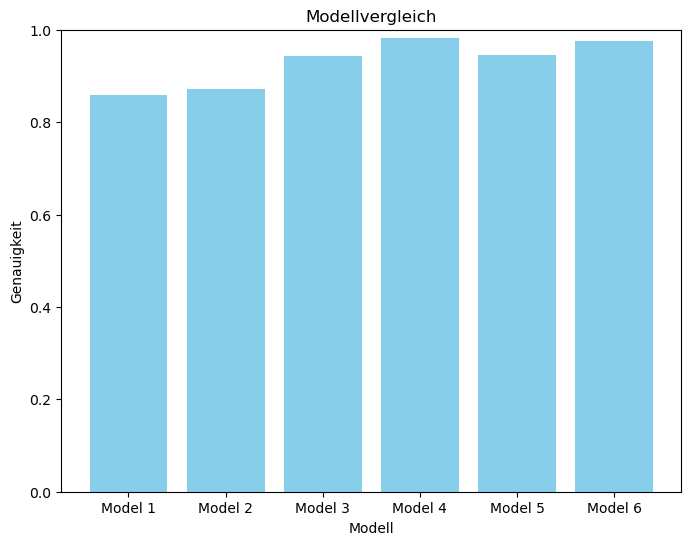

In [23]:
# Ergebnisse in einem DataFrame anzeigen
results_df = pd.DataFrame(results)
print(results_df)

# Ergebnisse visualisieren
plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.title('Modellvergleich')
plt.xlabel('Modell')
plt.ylabel('Genauigkeit')
plt.ylim(0, 1)
plt.show()


In [24]:
import visualkeras

for model, name in zip(models, model_names):
    # Modellarchitektur visualisieren
    visualkeras.layered_view(model, to_file=f'{name}_architecture.png').show()


28/28 [==============================] - 0s 7ms/step - loss: 0.3343 - accuracy: 0.8580
Model 1 - Test Loss: 0.33428671956062317
Model 1 - Test Accuracy: 0.8579545617103577
28/28 [==============================] - 0s 4ms/step


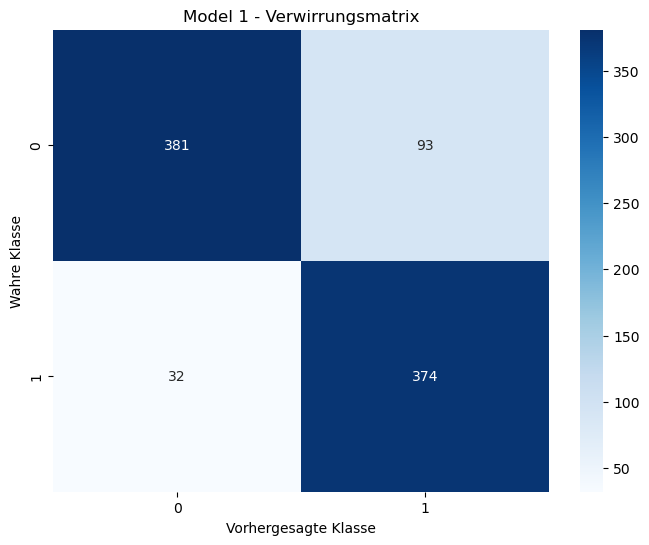

Model 1 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86       474
         1.0       0.80      0.92      0.86       406

    accuracy                           0.86       880
   macro avg       0.86      0.86      0.86       880
weighted avg       0.87      0.86      0.86       880

28/28 [==============================] - 0s 6ms/step - loss: 0.2936 - accuracy: 0.8727
Model 2 - Test Loss: 0.29361727833747864
Model 2 - Test Accuracy: 0.8727272748947144
28/28 [==============================] - 0s 4ms/step


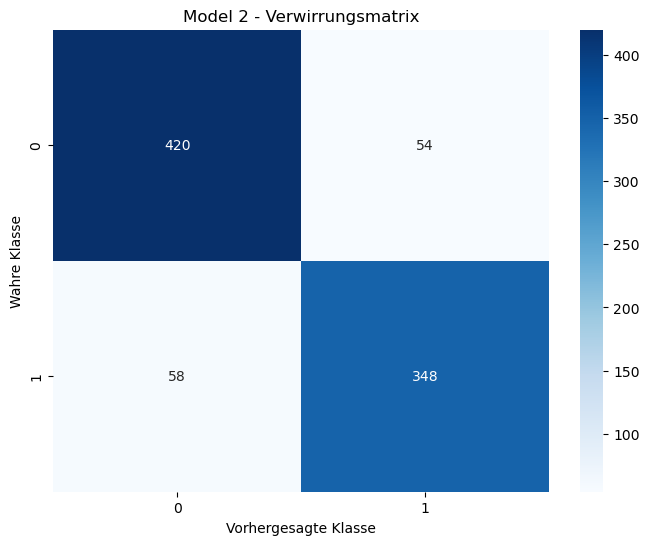

Model 2 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       474
         1.0       0.87      0.86      0.86       406

    accuracy                           0.87       880
   macro avg       0.87      0.87      0.87       880
weighted avg       0.87      0.87      0.87       880

28/28 [==============================] - 0s 7ms/step - loss: 0.1603 - accuracy: 0.9420
Model 3 - Test Loss: 0.16028349101543427
Model 3 - Test Accuracy: 0.9420454502105713
28/28 [==============================] - 0s 5ms/step


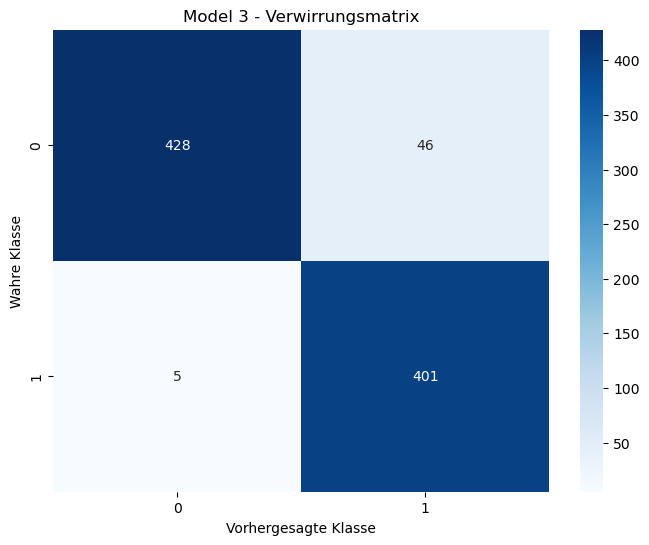

Model 3 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       474
         1.0       0.90      0.99      0.94       406

    accuracy                           0.94       880
   macro avg       0.94      0.95      0.94       880
weighted avg       0.95      0.94      0.94       880

28/28 [==============================] - 0s 8ms/step - loss: 0.0477 - accuracy: 0.9818
Model 4 - Test Loss: 0.04768354818224907
Model 4 - Test Accuracy: 0.9818181991577148
28/28 [==============================] - 0s 5ms/step


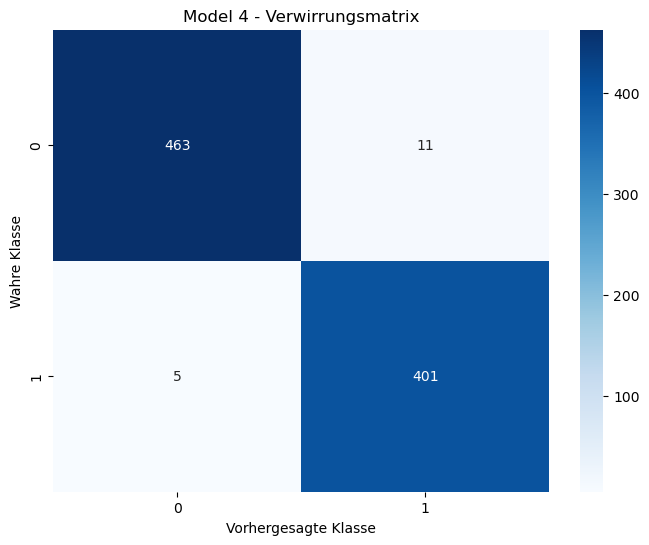

Model 4 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       474
         1.0       0.97      0.99      0.98       406

    accuracy                           0.98       880
   macro avg       0.98      0.98      0.98       880
weighted avg       0.98      0.98      0.98       880

28/28 [==============================] - 0s 9ms/step - loss: 0.1295 - accuracy: 0.9455
Model 5 - Test Loss: 0.12948313355445862
Model 5 - Test Accuracy: 0.9454545378684998
28/28 [==============================] - 0s 7ms/step


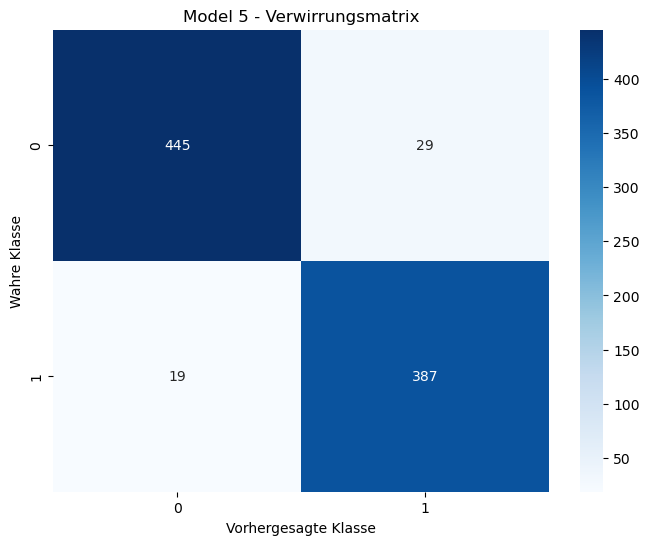

Model 5 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       474
         1.0       0.93      0.95      0.94       406

    accuracy                           0.95       880
   macro avg       0.94      0.95      0.95       880
weighted avg       0.95      0.95      0.95       880

28/28 [==============================] - 0s 7ms/step - loss: 0.0577 - accuracy: 0.9761
Model 6 - Test Loss: 0.05767379701137543
Model 6 - Test Accuracy: 0.9761363863945007
28/28 [==============================] - 0s 4ms/step


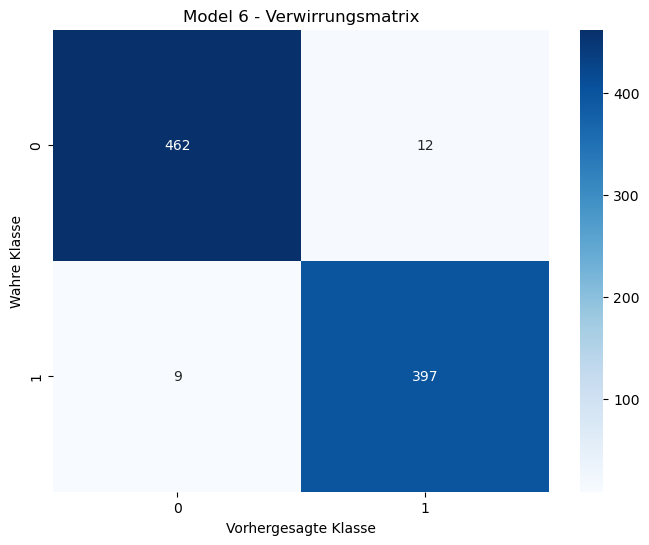

Model 6 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       474
         1.0       0.97      0.98      0.97       406

    accuracy                           0.98       880
   macro avg       0.98      0.98      0.98       880
weighted avg       0.98      0.98      0.98       880



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

for model, name in zip(models, model_names):
    # Modell bewerten
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{name} - Test Loss: {loss}")
    print(f"{name} - Test Accuracy: {accuracy}")

    # Vorhersagen auf dem Testdatensatz
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    # Verwirrungsmatrix erstellen
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Verwirrungsmatrix')
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Wahre Klasse')
    plt.show()

    # Klassifikationsbericht anzeigen
    print(f"{name} - Klassifikationsbericht")
    print(classification_report(y_test, y_pred_classes))


In [ ]:
import random
import string
from ipycanvas import Canvas
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Funktion zur Generierung eines zufälligen Strings
def generate_random_string(length=10):
    letters = string.ascii_lowercase + string.digits
    return ''.join(random.choice(letters) for i in range(length))

# Funktion zur Generierung eines Fingerabdrucks
def generate_random_canvas(txt):
    canvas = Canvas(width=280, height=35)
    canvas.fill_style = '#069'
    canvas.font = '18px Arial'
    canvas.fill_text(txt, 2, 15)
    canvas.fill_style = 'rgba(102, 204, 0, 0.7)'
    canvas.fill_text(txt, 4, 19)
    canvas.fill_style = '#069'
    canvas.fill_text(txt, 2, 23)
    canvas.fill_style = 'rgba(102, 204, 0, 0.7)'
    canvas.fill_text(txt, 4, 27)
    canvas.fill_style = '#069'
    canvas.fill_text(txt, 2, 31)
    canvas.fill_style = 'rgba(102, 204, 0, 0.7)'
    canvas.fill_text(txt, 4, 35)
    return canvas

# Zufälligen Text generieren
random_text = generate_random_string()
canvas = generate_random_canvas(random_text)
canvas


In [ ]:
# Funktion zum Konvertieren des Canvas in Bilddaten
def canvas_to_image_data(canvas):
    # Hier wird angenommen, dass der Canvas in ein Bild umgewandelt wird
    # und als numpy-Array zurückgegeben wird
    # Dies ist ein Platzhalter für die tatsächliche Implementierung
    # In der Praxis müsstest du den Canvas in ein Bild umwandeln und dann in ein numpy-Array konvertieren
    return np.random.rand(1, 28, 28, 1)  # Dummy-Daten

# Fingerabdruck generieren und in Bilddaten umwandeln
image_data = canvas_to_image_data(canvas)

# Modelle laden
model_paths = [
    'path_to_model_1.h5',
    'path_to_model_2.h5',
    'path_to_model_3.h5',
    'path_to_model_4.h5',
    'path_to_model_5.h5',
    'path_to_model_6.h5'
]

models = [load_model(path) for path in model_paths]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

# Modelle testen und Ergebnisse speichern
results = []
for model, name in zip(models, model_names):
    prediction = model.predict(image_data)
    results.append({'Model': name, 'Prediction': prediction[0][0]})

# Ergebnisse grafisch darstellen
fig, ax = plt.subplots()
ax.bar([result['Model'] for result in results], [result['Prediction'] for result in results])
ax.set_xlabel('Model')
ax.set_ylabel('Prediction')
ax.set_title('Model Predictions for Generated Fingerprint')
plt.show()
